In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 300
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001
EPSILON_PERT = 0.05

FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device("cpu")



In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state.float())
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].detach()
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones
        print(rewards)

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

## Training the network

In [3]:
agent = DQN_Solver()
agent.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0

    while True:
        action, q_values = agent.choose_action(state)
        
        state_, reward, done, info = env.step(action)
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)


/tmp/ipykernel_4888/3144857995.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 23.0 Best Reward 23.0 Last Reward 23.0 Epsilon 1.0
Episode 2 Average Reward 20.5 Best Reward 23.0 Last Reward 18.0 Epsilon 0.9900448802097482
Episode 3 Average Reward 23.0 Best Reward 28.0 Last Reward 28.0 Epsilon 0.9626946373158061
Episode 4 Average Reward 25.25 Best Reward 32.0 Last Reward 32.0 Epsilon 0.9323611649219127
Episode 5 Average Reward 24.0 Best Reward 32.0 Last Reward 19.0 Epsilon 0.914804836692645
Episode 6 Average Reward 23.666666666666668 Best Reward 32.0 Last Reward 22.0 Epsilon 0.8948890480710096
Episode 7 Average Reward 23.571428571428573 Best Reward 32.0 Last Reward 23.0 Epsilon 0.8745314299402548
Episode 8 Average Reward 25.125 Best Reward 36.0 Last Reward 36.0 Epsilon 0.8435930602951368
Episode 9 Average Reward 24.0 Best Reward 36.0 Last Reward 15.0 Epsilon 0.8310273589761736
Episode 10 Average Reward 24.3 Best Reward 36.0 Last Reward 27.0 Epsilon 0.8088788946494789
Episode 11 Average Reward 23.181818181818183 Best Reward 36.0 Last Reward 

Episode 81 Average Reward 80.08641975308642 Best Reward 307.0 Last Reward 242.0 Epsilon 0.001566000826532246
Episode 82 Average Reward 82.21951219512195 Best Reward 307.0 Last Reward 255.0 Epsilon 0.0012133650591660688
Episode 83 Average Reward 84.36144578313252 Best Reward 307.0 Last Reward 260.0 Epsilon 0.001
Episode 84 Average Reward 86.17857142857143 Best Reward 307.0 Last Reward 237.0 Epsilon 0.001
Episode 85 Average Reward 88.05882352941177 Best Reward 307.0 Last Reward 246.0 Epsilon 0.001
Episode 86 Average Reward 89.32558139534883 Best Reward 307.0 Last Reward 197.0 Epsilon 0.001
Episode 87 Average Reward 91.0919540229885 Best Reward 307.0 Last Reward 243.0 Epsilon 0.001
Episode 88 Average Reward 92.76136363636364 Best Reward 307.0 Last Reward 238.0 Epsilon 0.001
Episode 89 Average Reward 93.95505617977528 Best Reward 307.0 Last Reward 199.0 Epsilon 0.001
Episode 90 Average Reward 95.33333333333333 Best Reward 307.0 Last Reward 218.0 Epsilon 0.001
Episode 91 Average Reward 96.7

Episode 168 Average Reward 163.42261904761904 Best Reward 319.0 Last Reward 214.0 Epsilon 0.001
Episode 169 Average Reward 163.69230769230768 Best Reward 319.0 Last Reward 209.0 Epsilon 0.001
Episode 170 Average Reward 164.0529411764706 Best Reward 319.0 Last Reward 225.0 Epsilon 0.001
Episode 171 Average Reward 164.61988304093566 Best Reward 319.0 Last Reward 261.0 Epsilon 0.001
Episode 172 Average Reward 165.4360465116279 Best Reward 319.0 Last Reward 305.0 Epsilon 0.001
Episode 173 Average Reward 165.7456647398844 Best Reward 319.0 Last Reward 219.0 Epsilon 0.001
Episode 174 Average Reward 166.04597701149424 Best Reward 319.0 Last Reward 218.0 Epsilon 0.001
Episode 175 Average Reward 166.42857142857142 Best Reward 319.0 Last Reward 233.0 Epsilon 0.001
Episode 176 Average Reward 166.88636363636363 Best Reward 319.0 Last Reward 247.0 Epsilon 0.001
Episode 177 Average Reward 167.58757062146893 Best Reward 319.0 Last Reward 291.0 Epsilon 0.001
Episode 178 Average Reward 168.224719101123

Episode 254 Average Reward 188.7204724409449 Best Reward 319.0 Last Reward 225.0 Epsilon 0.001
Episode 255 Average Reward 188.34509803921569 Best Reward 319.0 Last Reward 93.0 Epsilon 0.001
Episode 256 Average Reward 187.640625 Best Reward 319.0 Last Reward 8.0 Epsilon 0.001
Episode 257 Average Reward 186.94941634241246 Best Reward 319.0 Last Reward 10.0 Epsilon 0.001
Episode 258 Average Reward 186.26356589147287 Best Reward 319.0 Last Reward 10.0 Epsilon 0.001
Episode 259 Average Reward 185.58687258687257 Best Reward 319.0 Last Reward 11.0 Epsilon 0.001
Episode 260 Average Reward 184.90384615384616 Best Reward 319.0 Last Reward 8.0 Epsilon 0.001
Episode 261 Average Reward 184.23371647509578 Best Reward 319.0 Last Reward 10.0 Epsilon 0.001
Episode 262 Average Reward 183.5648854961832 Best Reward 319.0 Last Reward 9.0 Epsilon 0.001
Episode 263 Average Reward 182.93916349809885 Best Reward 319.0 Last Reward 19.0 Epsilon 0.001
Episode 264 Average Reward 182.31439393939394 Best Reward 319.

## Testing the network

In [19]:
agent.network.eval()

best_reward = 0

episode_number = []
average_reward_number_attacked = []
epsilons_attacks = [0,0.1, .2, 0.3, .4, 0.5, .6, 0.7, .8, .9, 1] 


for epsilon in epsilons_attacks:
    average_reward_attacked = 0
    print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
    for i in range(1,EPISODES_TEST):
        state = env.reset()
        score = 0
        did_pertubate = 0
        while True:
            #env.render()
            action, q_values = agent.choose_action(state)
            state_, reward, done, info = env.step(action)

            if score % 1 == 0 and not(isinstance(q_values,float)):
                next_q_values = agent.network(state_.to(DEVICE).float()).detach()
                q_target = reward + GAMMA * next_q_values * done
                loss = agent.network.loss(q_values, q_target)
                gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
                state = state + gradient_sign * epsilon
                action, q_values = agent.choose_action(state)
                state_, reward, done, info = env.step(action)
                did_pertubate += 1

            state = state_
            score += reward

            if done:            
                if score > best_reward:
                    best_reward = score
                average_reward_attacked += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
    
    average_reward_number_attacked.append(average_reward_attacked / i)
    
    
plt.ioff()
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_attacked)


NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 108.0 Best Reward 108.0 Last Reward 108.0 Epsilon 0.001
Episode 2 Average Reward 113.5 Best Reward 119.0 Last Reward 119.0 Epsilon 0.001
Episode 3 Average Reward 114.0 Best Reward 119.0 Last Reward 115.0 Epsilon 0.001
Episode 4 Average Reward 117.5 Best Reward 128.0 Last Reward 128.0 Epsilon 0.001
Episode 5 Average Reward 118.6 Best Reward 128.0 Last Reward 123.0 Epsilon 0.001
Episode 6 Average Reward 117.33333333333333 Best Reward 128.0 Last Reward 111.0 Epsilon 0.001
Episode 7 Average Reward 117.28571428571429 Best Reward 128.0 Last Reward 117.0 Epsilon 0.001
Episode 8 Average Reward 116.75 Best Reward 128.0 Last Reward 113.0 Epsilon 0.001
Episode 9 Average Reward 116.33333333333333 Best Reward 128.0 Last Reward 113.0 Epsilon 0.001
Episode 10 Average Reward 116.1 Best Reward 128.0 Last Reward 114.0 Epsilon 0.001
Episode 11 Average Reward 116.81818181818181 Best Reward 128.0 Last Reward 124.0 Epsilon 0.001
Episode

Episode 90 Average Reward 119.78888888888889 Best Reward 139.0 Last Reward 129.0 Epsilon 0.001
Episode 91 Average Reward 119.79120879120879 Best Reward 139.0 Last Reward 120.0 Epsilon 0.001
Episode 92 Average Reward 119.82608695652173 Best Reward 139.0 Last Reward 123.0 Epsilon 0.001
Episode 93 Average Reward 119.82795698924731 Best Reward 139.0 Last Reward 120.0 Epsilon 0.001
Episode 94 Average Reward 119.84042553191489 Best Reward 139.0 Last Reward 121.0 Epsilon 0.001
Episode 95 Average Reward 119.86315789473684 Best Reward 139.0 Last Reward 122.0 Epsilon 0.001
Episode 96 Average Reward 119.88541666666667 Best Reward 139.0 Last Reward 122.0 Epsilon 0.001
Episode 97 Average Reward 119.85567010309278 Best Reward 139.0 Last Reward 117.0 Epsilon 0.001
Episode 98 Average Reward 119.79591836734694 Best Reward 139.0 Last Reward 114.0 Epsilon 0.001
Episode 99 Average Reward 119.78787878787878 Best Reward 139.0 Last Reward 119.0 Epsilon 0.001
Episode 100 Average Reward 119.74 Best Reward 139.

Episode 30 Average Reward 99.0 Best Reward 141.0 Last Reward 104.0 Epsilon 0.001
Episode 31 Average Reward 98.96774193548387 Best Reward 141.0 Last Reward 98.0 Epsilon 0.001
Episode 32 Average Reward 99.09375 Best Reward 141.0 Last Reward 103.0 Epsilon 0.001
Episode 33 Average Reward 99.0 Best Reward 141.0 Last Reward 96.0 Epsilon 0.001
Episode 34 Average Reward 99.26470588235294 Best Reward 141.0 Last Reward 108.0 Epsilon 0.001
Episode 35 Average Reward 99.31428571428572 Best Reward 141.0 Last Reward 101.0 Epsilon 0.001
Episode 36 Average Reward 99.19444444444444 Best Reward 141.0 Last Reward 95.0 Epsilon 0.001
Episode 37 Average Reward 99.21621621621621 Best Reward 141.0 Last Reward 100.0 Epsilon 0.001
Episode 38 Average Reward 99.28947368421052 Best Reward 141.0 Last Reward 102.0 Epsilon 0.001
Episode 39 Average Reward 99.2051282051282 Best Reward 141.0 Last Reward 96.0 Epsilon 0.001
Episode 40 Average Reward 99.375 Best Reward 141.0 Last Reward 106.0 Epsilon 0.001
Episode 41 Averag

Episode 120 Average Reward 98.84166666666667 Best Reward 141.0 Last Reward 98.0 Epsilon 0.001
Episode 121 Average Reward 98.85950413223141 Best Reward 141.0 Last Reward 101.0 Epsilon 0.001
Episode 122 Average Reward 98.91803278688525 Best Reward 141.0 Last Reward 106.0 Epsilon 0.001
Episode 123 Average Reward 98.90243902439025 Best Reward 141.0 Last Reward 97.0 Epsilon 0.001
Episode 124 Average Reward 98.88709677419355 Best Reward 141.0 Last Reward 97.0 Epsilon 0.001
Episode 125 Average Reward 98.928 Best Reward 141.0 Last Reward 104.0 Epsilon 0.001
Episode 126 Average Reward 98.93650793650794 Best Reward 141.0 Last Reward 100.0 Epsilon 0.001
Episode 127 Average Reward 98.94488188976378 Best Reward 141.0 Last Reward 100.0 Epsilon 0.001
Episode 128 Average Reward 98.9375 Best Reward 141.0 Last Reward 98.0 Epsilon 0.001
Episode 129 Average Reward 98.97674418604652 Best Reward 141.0 Last Reward 104.0 Epsilon 0.001
Episode 130 Average Reward 99.01538461538462 Best Reward 141.0 Last Reward 

Episode 64 Average Reward 11.8125 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 65 Average Reward 11.784615384615385 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 66 Average Reward 11.803030303030303 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 67 Average Reward 11.82089552238806 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 68 Average Reward 11.838235294117647 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 69 Average Reward 11.81159420289855 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 70 Average Reward 11.785714285714286 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 71 Average Reward 11.830985915492958 Best Reward 141.0 Last Reward 15.0 Epsilon 0.001
Episode 72 Average Reward 11.819444444444445 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 73 Average Reward 11.808219178082192 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 74 Average Reward 11.837837837837839 Best Reward 141.0 Last Rewar

Episode 7 Average Reward 10.571428571428571 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 8 Average Reward 10.5 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 9 Average Reward 10.444444444444445 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 10 Average Reward 10.6 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 11 Average Reward 10.636363636363637 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 12 Average Reward 10.5 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 13 Average Reward 10.538461538461538 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 14 Average Reward 10.571428571428571 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 15 Average Reward 10.4 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 16 Average Reward 10.3125 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 17 Average Reward 10.176470588235293 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 18 Average Reward 10.11111111111

Episode 111 Average Reward 9.91891891891892 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 112 Average Reward 9.910714285714286 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 113 Average Reward 9.893805309734514 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 114 Average Reward 9.894736842105264 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 115 Average Reward 9.88695652173913 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 116 Average Reward 9.89655172413793 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 117 Average Reward 9.914529914529915 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 118 Average Reward 9.889830508474576 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 119 Average Reward 9.882352941176471 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 120 Average Reward 9.883333333333333 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 121 Average Reward 9.892561983471074 Best Reward 141.0 Last 

Episode 62 Average Reward 9.387096774193548 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 63 Average Reward 9.34920634920635 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 64 Average Reward 9.328125 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 65 Average Reward 9.353846153846154 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 66 Average Reward 9.363636363636363 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 67 Average Reward 9.35820895522388 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 68 Average Reward 9.352941176470589 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 69 Average Reward 9.347826086956522 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 70 Average Reward 9.342857142857143 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 71 Average Reward 9.338028169014084 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 72 Average Reward 9.347222222222221 Best Reward 141.0 Last Reward 10.0 Epsilon 0.

Episode 2 Average Reward 8.0 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 3 Average Reward 8.333333333333334 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 4 Average Reward 8.5 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 5 Average Reward 8.4 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 6 Average Reward 8.166666666666666 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 7 Average Reward 8.571428571428571 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 8 Average Reward 8.375 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 9 Average Reward 8.333333333333334 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 10 Average Reward 8.2 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 11 Average Reward 8.454545454545455 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 12 Average Reward 8.5 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 13 Average Reward 8.461538461538462 Best Reward 141.0 Last Reward 8.

Episode 104 Average Reward 9.663461538461538 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 105 Average Reward 9.657142857142857 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 106 Average Reward 9.641509433962264 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 107 Average Reward 9.644859813084112 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 108 Average Reward 9.62037037037037 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 109 Average Reward 9.623853211009175 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 110 Average Reward 9.618181818181819 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 111 Average Reward 9.603603603603604 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 112 Average Reward 9.580357142857142 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 113 Average Reward 9.56637168141593 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 114 Average Reward 9.570175438596491 Best Reward 141.0 Last Re

Episode 58 Average Reward 9.551724137931034 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 59 Average Reward 9.508474576271187 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 60 Average Reward 9.516666666666667 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 61 Average Reward 9.508196721311476 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 62 Average Reward 9.483870967741936 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 63 Average Reward 9.492063492063492 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 64 Average Reward 9.484375 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 65 Average Reward 9.492307692307692 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 66 Average Reward 9.469696969696969 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 67 Average Reward 9.447761194029852 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 68 Average Reward 9.426470588235293 Best Reward 141.0 Last Reward 8.0 Epsilon

Episode 7 Average Reward 9.0 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 8 Average Reward 9.125 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 9 Average Reward 8.88888888888889 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 10 Average Reward 9.3 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 11 Average Reward 9.272727272727273 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 12 Average Reward 9.083333333333334 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 13 Average Reward 9.0 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 14 Average Reward 9.0 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 15 Average Reward 9.133333333333333 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 16 Average Reward 9.25 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 17 Average Reward 9.235294117647058 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 18 Average Reward 9.11111111111111 Best Reward 141.0 Last Rew

Episode 107 Average Reward 9.495327102803738 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 108 Average Reward 9.527777777777779 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 109 Average Reward 9.522935779816514 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 110 Average Reward 9.527272727272727 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 111 Average Reward 9.522522522522523 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 112 Average Reward 9.535714285714286 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 113 Average Reward 9.557522123893806 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 114 Average Reward 9.543859649122806 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 115 Average Reward 9.530434782608696 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 116 Average Reward 9.517241379310345 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 117 Average Reward 9.521367521367521 Best Reward 141.0 Las

Episode 55 Average Reward 9.327272727272728 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 56 Average Reward 9.303571428571429 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 57 Average Reward 9.350877192982455 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 58 Average Reward 9.344827586206897 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 59 Average Reward 9.40677966101695 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 60 Average Reward 9.383333333333333 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 61 Average Reward 9.39344262295082 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 62 Average Reward 9.435483870967742 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 63 Average Reward 9.412698412698413 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 64 Average Reward 9.390625 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 65 Average Reward 9.384615384615385 Best Reward 141.0 Last Reward 9.0 Epsilon 0

Episode 147 Average Reward 9.782312925170068 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 148 Average Reward 9.79054054054054 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 149 Average Reward 9.78523489932886 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.9
Episode 1 Average Reward 9.0 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 2 Average Reward 10.5 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 3 Average Reward 10.666666666666666 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 4 Average Reward 10.0 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 5 Average Reward 9.8 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 6 Average Reward 9.5 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 7 Average Reward 9.428571428571429 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 8 Average Reward 9.75 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 9 Average Rew

Episode 100 Average Reward 9.64 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 101 Average Reward 9.673267326732674 Best Reward 141.0 Last Reward 13.0 Epsilon 0.001
Episode 102 Average Reward 9.686274509803921 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 103 Average Reward 9.70873786407767 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 104 Average Reward 9.701923076923077 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 105 Average Reward 9.704761904761904 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 106 Average Reward 9.745283018867925 Best Reward 141.0 Last Reward 14.0 Epsilon 0.001
Episode 107 Average Reward 9.766355140186915 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 108 Average Reward 9.787037037037036 Best Reward 141.0 Last Reward 12.0 Epsilon 0.001
Episode 109 Average Reward 9.770642201834862 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 110 Average Reward 9.772727272727273 Best Reward 141.0 Last Reward 1

Episode 50 Average Reward 9.56 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 51 Average Reward 9.588235294117647 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 52 Average Reward 9.615384615384615 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 53 Average Reward 9.641509433962264 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 54 Average Reward 9.592592592592593 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 55 Average Reward 9.6 Best Reward 141.0 Last Reward 10.0 Epsilon 0.001
Episode 56 Average Reward 9.589285714285714 Best Reward 141.0 Last Reward 9.0 Epsilon 0.001
Episode 57 Average Reward 9.56140350877193 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 58 Average Reward 9.517241379310345 Best Reward 141.0 Last Reward 7.0 Epsilon 0.001
Episode 59 Average Reward 9.491525423728813 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 60 Average Reward 9.566666666666666 Best Reward 141.0 Last Reward 14.0 Epsilon 0.001
Episode 61 

Episode 145 Average Reward 9.63448275862069 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001
Episode 146 Average Reward 9.623287671232877 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 147 Average Reward 9.612244897959183 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 148 Average Reward 9.60135135135135 Best Reward 141.0 Last Reward 8.0 Epsilon 0.001
Episode 149 Average Reward 9.610738255033556 Best Reward 141.0 Last Reward 11.0 Epsilon 0.001


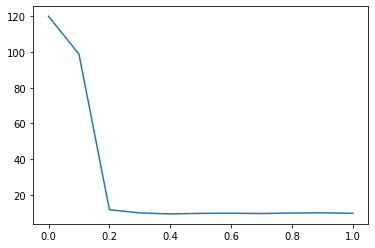

In [20]:
plt.show()

## Training with adversarial training

In [28]:
agent_robust = DQN_Solver()
agent_robust.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0
    while True:
        action, q_values = agent_robust.choose_action(state)
        state_, reward, done, info = env.step(action)
        
#         if score % 1 == 0 and not(isinstance(q_values,float)):
#             next_q_values = agent_robust.network(state_.to(DEVICE).float()).detach()
#             loss = agent_robust.network.loss(q_values, next_q_values)
#             gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
#             state = state + gradient_sign * 0.15 
#             action, q_values = agent_robust.choose_action(state)
#             state_, reward, done, info = env.step(action)

        if score % 1 == 0 and not(isinstance(q_values,float)):
            next_q_values = agent.network(state_.to(DEVICE).float()).detach()
            q_target = reward + GAMMA * next_q_values * done
            loss = agent.network.loss(q_values, q_target)
            gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
            state = state + gradient_sign * EPSILON_PERT
            action, q_values = agent.choose_action(state)
            state_, reward, done, info = env.step(action)
            did_pertubate += 1
         
                
        agent_robust.memory.add(state, action, reward, state_, done)
        agent_robust.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)

/tmp/ipykernel_4888/3144857995.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 23.0 Best Reward 23.0 Last Reward 23.0 Epsilon 0.001
Episode 2 Average Reward 18.5 Best Reward 23.0 Last Reward 14.0 Epsilon 0.001
Episode 3 Average Reward 20.666666666666668 Best Reward 25.0 Last Reward 25.0 Epsilon 0.001
Episode 4 Average Reward 18.5 Best Reward 25.0 Last Reward 12.0 Epsilon 0.001
Episode 5 Average Reward 21.4 Best Reward 33.0 Last Reward 33.0 Epsilon 0.001
Episode 6 Average Reward 20.5 Best Reward 33.0 Last Reward 16.0 Epsilon 0.001
Episode 7 Average Reward 18.714285714285715 Best Reward 33.0 Last Reward 8.0 Epsilon 0.001
Episode 8 Average Reward 18.5 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 9 Average Reward 18.77777777777778 Best Reward 33.0 Last Reward 21.0 Epsilon 0.001
Episode 10 Average Reward 18.4 Best Reward 33.0 Last Reward 15.0 Epsilon 0.001
Episode 11 Average Reward 18.0 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 12 Average Reward 18.666666666666668 Best Reward 33.0 Last Reward 26.0 Epsilon 0.001
Episode

Episode 93 Average Reward 42.16129032258065 Best Reward 161.0 Last Reward 89.0 Epsilon 0.001
Episode 94 Average Reward 43.138297872340424 Best Reward 161.0 Last Reward 134.0 Epsilon 0.001
Episode 95 Average Reward 43.76842105263158 Best Reward 161.0 Last Reward 103.0 Epsilon 0.001
Episode 96 Average Reward 44.65625 Best Reward 161.0 Last Reward 129.0 Epsilon 0.001
Episode 97 Average Reward 45.41237113402062 Best Reward 161.0 Last Reward 118.0 Epsilon 0.001
Episode 98 Average Reward 46.0 Best Reward 161.0 Last Reward 103.0 Epsilon 0.001
Episode 99 Average Reward 46.81818181818182 Best Reward 161.0 Last Reward 127.0 Epsilon 0.001
Episode 100 Average Reward 47.44 Best Reward 161.0 Last Reward 109.0 Epsilon 0.001
Episode 101 Average Reward 48.06930693069307 Best Reward 161.0 Last Reward 111.0 Epsilon 0.001
Episode 102 Average Reward 48.61764705882353 Best Reward 161.0 Last Reward 104.0 Epsilon 0.001
Episode 103 Average Reward 49.320388349514566 Best Reward 161.0 Last Reward 121.0 Epsilon 0

Episode 181 Average Reward 78.3646408839779 Best Reward 193.0 Last Reward 68.0 Epsilon 0.001
Episode 182 Average Reward 78.03846153846153 Best Reward 193.0 Last Reward 19.0 Epsilon 0.001
Episode 183 Average Reward 77.72677595628416 Best Reward 193.0 Last Reward 21.0 Epsilon 0.001
Episode 184 Average Reward 77.41847826086956 Best Reward 193.0 Last Reward 21.0 Epsilon 0.001
Episode 185 Average Reward 77.08108108108108 Best Reward 193.0 Last Reward 15.0 Epsilon 0.001
Episode 186 Average Reward 76.76344086021506 Best Reward 193.0 Last Reward 18.0 Epsilon 0.001
Episode 187 Average Reward 76.44385026737967 Best Reward 193.0 Last Reward 17.0 Epsilon 0.001
Episode 188 Average Reward 76.13829787234043 Best Reward 193.0 Last Reward 19.0 Epsilon 0.001
Episode 189 Average Reward 75.84656084656085 Best Reward 193.0 Last Reward 21.0 Epsilon 0.001
Episode 190 Average Reward 75.54736842105264 Best Reward 193.0 Last Reward 19.0 Epsilon 0.001
Episode 191 Average Reward 75.24083769633508 Best Reward 193.

Episode 269 Average Reward 82.92193308550186 Best Reward 193.0 Last Reward 150.0 Epsilon 0.001
Episode 270 Average Reward 83.14814814814815 Best Reward 193.0 Last Reward 144.0 Epsilon 0.001
Episode 271 Average Reward 83.44280442804428 Best Reward 193.0 Last Reward 163.0 Epsilon 0.001
Episode 272 Average Reward 83.55882352941177 Best Reward 193.0 Last Reward 115.0 Epsilon 0.001
Episode 273 Average Reward 84.07692307692308 Best Reward 225.0 Last Reward 225.0 Epsilon 0.001
Episode 274 Average Reward 84.16423357664233 Best Reward 225.0 Last Reward 108.0 Epsilon 0.001
Episode 275 Average Reward 84.77090909090909 Best Reward 251.0 Last Reward 251.0 Epsilon 0.001
Episode 276 Average Reward 85.3695652173913 Best Reward 251.0 Last Reward 250.0 Epsilon 0.001
Episode 277 Average Reward 85.88447653429603 Best Reward 251.0 Last Reward 228.0 Epsilon 0.001
Episode 278 Average Reward 86.17625899280576 Best Reward 251.0 Last Reward 167.0 Epsilon 0.001
Episode 279 Average Reward 86.41935483870968 Best R

## Testing robust network

Episode 1 Average Reward 250.0 Best Reward 250.0 Last Reward 250.0 Epsilon 0.001
Episode 2 Average Reward 250.0 Best Reward 250.0 Last Reward 250.0 Epsilon 0.001
Episode 3 Average Reward 250.0 Best Reward 250.0 Last Reward 250.0 Epsilon 0.001
Episode 4 Average Reward 250.25 Best Reward 251.0 Last Reward 251.0 Epsilon 0.001
Episode 5 Average Reward 250.2 Best Reward 251.0 Last Reward 250.0 Epsilon 0.001
Episode 6 Average Reward 250.16666666666666 Best Reward 251.0 Last Reward 250.0 Epsilon 0.001
Episode 7 Average Reward 250.14285714285714 Best Reward 251.0 Last Reward 250.0 Epsilon 0.001
Episode 8 Average Reward 250.125 Best Reward 251.0 Last Reward 250.0 Epsilon 0.001
Episode 9 Average Reward 250.22222222222223 Best Reward 251.0 Last Reward 251.0 Epsilon 0.001
Episode 10 Average Reward 250.3 Best Reward 251.0 Last Reward 251.0 Epsilon 0.001
Episode 11 Average Reward 250.27272727272728 Best Reward 251.0 Last Reward 250.0 Epsilon 0.001
Episode 12 Average Reward 250.25 Best Reward 251.0 L

Episode 91 Average Reward 248.6043956043956 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 92 Average Reward 248.6195652173913 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 93 Average Reward 248.6451612903226 Best Reward 252.0 Last Reward 251.0 Epsilon 0.001
Episode 94 Average Reward 248.6595744680851 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 95 Average Reward 248.67368421052632 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 96 Average Reward 248.69791666666666 Best Reward 252.0 Last Reward 251.0 Epsilon 0.001
Episode 97 Average Reward 248.71134020618555 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 98 Average Reward 248.72448979591837 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 99 Average Reward 248.74747474747474 Best Reward 252.0 Last Reward 251.0 Epsilon 0.001
Episode 100 Average Reward 248.76 Best Reward 252.0 Last Reward 250.0 Epsilon 0.001
Episode 101 Average Reward 248.77227722772278 Best Reward 252.0 L

Episode 32 Average Reward 57.59375 Best Reward 252.0 Last Reward 48.0 Epsilon 0.001
Episode 33 Average Reward 57.878787878787875 Best Reward 252.0 Last Reward 67.0 Epsilon 0.001
Episode 34 Average Reward 57.38235294117647 Best Reward 252.0 Last Reward 41.0 Epsilon 0.001
Episode 35 Average Reward 58.34285714285714 Best Reward 252.0 Last Reward 91.0 Epsilon 0.001
Episode 36 Average Reward 58.166666666666664 Best Reward 252.0 Last Reward 52.0 Epsilon 0.001
Episode 37 Average Reward 58.027027027027025 Best Reward 252.0 Last Reward 53.0 Epsilon 0.001
Episode 38 Average Reward 57.68421052631579 Best Reward 252.0 Last Reward 45.0 Epsilon 0.001
Episode 39 Average Reward 57.282051282051285 Best Reward 252.0 Last Reward 42.0 Epsilon 0.001
Episode 40 Average Reward 56.9 Best Reward 252.0 Last Reward 42.0 Epsilon 0.001
Episode 41 Average Reward 56.5609756097561 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 42 Average Reward 56.69047619047619 Best Reward 252.0 Last Reward 62.0 Epsilon 0.

Episode 122 Average Reward 55.40163934426229 Best Reward 252.0 Last Reward 59.0 Epsilon 0.001
Episode 123 Average Reward 55.3739837398374 Best Reward 252.0 Last Reward 52.0 Epsilon 0.001
Episode 124 Average Reward 55.346774193548384 Best Reward 252.0 Last Reward 52.0 Epsilon 0.001
Episode 125 Average Reward 55.264 Best Reward 252.0 Last Reward 45.0 Epsilon 0.001
Episode 126 Average Reward 55.15079365079365 Best Reward 252.0 Last Reward 41.0 Epsilon 0.001
Episode 127 Average Reward 55.10236220472441 Best Reward 252.0 Last Reward 49.0 Epsilon 0.001
Episode 128 Average Reward 55.1171875 Best Reward 252.0 Last Reward 57.0 Epsilon 0.001
Episode 129 Average Reward 55.06201550387597 Best Reward 252.0 Last Reward 48.0 Epsilon 0.001
Episode 130 Average Reward 54.96153846153846 Best Reward 252.0 Last Reward 42.0 Epsilon 0.001
Episode 131 Average Reward 54.86259541984733 Best Reward 252.0 Last Reward 42.0 Epsilon 0.001
Episode 132 Average Reward 54.878787878787875 Best Reward 252.0 Last Reward 57

Episode 65 Average Reward 34.93846153846154 Best Reward 252.0 Last Reward 39.0 Epsilon 0.001
Episode 66 Average Reward 35.06060606060606 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 67 Average Reward 34.92537313432836 Best Reward 252.0 Last Reward 26.0 Epsilon 0.001
Episode 68 Average Reward 34.8235294117647 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 69 Average Reward 34.98550724637681 Best Reward 252.0 Last Reward 46.0 Epsilon 0.001
Episode 70 Average Reward 34.9 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 71 Average Reward 34.80281690140845 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 72 Average Reward 34.81944444444444 Best Reward 252.0 Last Reward 36.0 Epsilon 0.001
Episode 73 Average Reward 34.76712328767123 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 74 Average Reward 34.7972972972973 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 75 Average Reward 34.93333333333333 Best Reward 252.0 Last Reward 45.0 Epsilo

Episode 5 Average Reward 34.6 Best Reward 252.0 Last Reward 64.0 Epsilon 0.001
Episode 6 Average Reward 33.5 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 7 Average Reward 33.142857142857146 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 8 Average Reward 32.375 Best Reward 252.0 Last Reward 27.0 Epsilon 0.001
Episode 9 Average Reward 33.55555555555556 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 10 Average Reward 33.4 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 11 Average Reward 32.63636363636363 Best Reward 252.0 Last Reward 25.0 Epsilon 0.001
Episode 12 Average Reward 33.5 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 13 Average Reward 32.84615384615385 Best Reward 252.0 Last Reward 25.0 Epsilon 0.001
Episode 14 Average Reward 32.785714285714285 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 15 Average Reward 32.333333333333336 Best Reward 252.0 Last Reward 26.0 Epsilon 0.001
Episode 16 Average Reward 32.375 Best Rewa

Episode 96 Average Reward 33.947916666666664 Best Reward 252.0 Last Reward 26.0 Epsilon 0.001
Episode 97 Average Reward 33.855670103092784 Best Reward 252.0 Last Reward 25.0 Epsilon 0.001
Episode 98 Average Reward 34.234693877551024 Best Reward 252.0 Last Reward 71.0 Epsilon 0.001
Episode 99 Average Reward 34.323232323232325 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 100 Average Reward 34.41 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 101 Average Reward 34.45544554455446 Best Reward 252.0 Last Reward 39.0 Epsilon 0.001
Episode 102 Average Reward 34.44117647058823 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 103 Average Reward 34.310679611650485 Best Reward 252.0 Last Reward 21.0 Epsilon 0.001
Episode 104 Average Reward 34.21153846153846 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 105 Average Reward 34.20952380952381 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 106 Average Reward 34.33018867924528 Best Reward 252.0 Last Rew

Episode 38 Average Reward 32.078947368421055 Best Reward 252.0 Last Reward 25.0 Epsilon 0.001
Episode 39 Average Reward 32.15384615384615 Best Reward 252.0 Last Reward 35.0 Epsilon 0.001
Episode 40 Average Reward 32.2 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 41 Average Reward 31.951219512195124 Best Reward 252.0 Last Reward 22.0 Epsilon 0.001
Episode 42 Average Reward 32.07142857142857 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 43 Average Reward 31.837209302325583 Best Reward 252.0 Last Reward 22.0 Epsilon 0.001
Episode 44 Average Reward 32.06818181818182 Best Reward 252.0 Last Reward 42.0 Epsilon 0.001
Episode 45 Average Reward 32.22222222222222 Best Reward 252.0 Last Reward 39.0 Epsilon 0.001
Episode 46 Average Reward 32.04347826086956 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 47 Average Reward 32.02127659574468 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 48 Average Reward 31.9375 Best Reward 252.0 Last Reward 28.0 Epsilon 0.0

Episode 127 Average Reward 32.69291338582677 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 128 Average Reward 32.6640625 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 129 Average Reward 32.5968992248062 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 130 Average Reward 32.60769230769231 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 131 Average Reward 32.67175572519084 Best Reward 252.0 Last Reward 41.0 Epsilon 0.001
Episode 132 Average Reward 32.68181818181818 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 133 Average Reward 32.6390977443609 Best Reward 252.0 Last Reward 27.0 Epsilon 0.001
Episode 134 Average Reward 32.76119402985075 Best Reward 252.0 Last Reward 49.0 Epsilon 0.001
Episode 135 Average Reward 32.72592592592593 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 136 Average Reward 32.720588235294116 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 137 Average Reward 32.737226277372265 Best Reward 252.0 Last

Episode 70 Average Reward 33.27142857142857 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 71 Average Reward 33.16901408450704 Best Reward 252.0 Last Reward 26.0 Epsilon 0.001
Episode 72 Average Reward 33.125 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 73 Average Reward 33.16438356164384 Best Reward 252.0 Last Reward 36.0 Epsilon 0.001
Episode 74 Average Reward 33.21621621621622 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 75 Average Reward 33.586666666666666 Best Reward 252.0 Last Reward 61.0 Epsilon 0.001
Episode 76 Average Reward 33.526315789473685 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 77 Average Reward 33.532467532467535 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 78 Average Reward 33.48717948717949 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 79 Average Reward 33.721518987341774 Best Reward 252.0 Last Reward 52.0 Epsilon 0.001
Episode 80 Average Reward 33.7375 Best Reward 252.0 Last Reward 35.0 Epsilon 

Episode 12 Average Reward 31.75 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 13 Average Reward 32.76923076923077 Best Reward 252.0 Last Reward 45.0 Epsilon 0.001
Episode 14 Average Reward 33.0 Best Reward 252.0 Last Reward 36.0 Epsilon 0.001
Episode 15 Average Reward 32.86666666666667 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 16 Average Reward 33.0625 Best Reward 252.0 Last Reward 36.0 Epsilon 0.001
Episode 17 Average Reward 34.0 Best Reward 252.0 Last Reward 49.0 Epsilon 0.001
Episode 18 Average Reward 33.72222222222222 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 19 Average Reward 33.89473684210526 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 20 Average Reward 33.85 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 21 Average Reward 33.904761904761905 Best Reward 252.0 Last Reward 35.0 Epsilon 0.001
Episode 22 Average Reward 33.22727272727273 Best Reward 252.0 Last Reward 19.0 Epsilon 0.001
Episode 23 Average Reward 32.7826086

Episode 103 Average Reward 33.09708737864078 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 104 Average Reward 32.99038461538461 Best Reward 252.0 Last Reward 22.0 Epsilon 0.001
Episode 105 Average Reward 32.94285714285714 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 106 Average Reward 32.89622641509434 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 107 Average Reward 32.86915887850467 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 108 Average Reward 32.824074074074076 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 109 Average Reward 33.00917431192661 Best Reward 252.0 Last Reward 53.0 Epsilon 0.001
Episode 110 Average Reward 33.1 Best Reward 252.0 Last Reward 43.0 Epsilon 0.001
Episode 111 Average Reward 33.090090090090094 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 112 Average Reward 33.035714285714285 Best Reward 252.0 Last Reward 27.0 Epsilon 0.001
Episode 113 Average Reward 32.982300884955755 Best Reward 252.0 Last R

Episode 47 Average Reward 33.59574468085106 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 48 Average Reward 33.520833333333336 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 49 Average Reward 33.42857142857143 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 50 Average Reward 33.22 Best Reward 252.0 Last Reward 23.0 Epsilon 0.001
Episode 51 Average Reward 33.19607843137255 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 52 Average Reward 33.21153846153846 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 53 Average Reward 33.16981132075472 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 54 Average Reward 33.25925925925926 Best Reward 252.0 Last Reward 38.0 Epsilon 0.001
Episode 55 Average Reward 33.09090909090909 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 56 Average Reward 33.160714285714285 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 57 Average Reward 33.01754385964912 Best Reward 252.0 Last Reward 25.0 E

Episode 137 Average Reward 32.44525547445255 Best Reward 252.0 Last Reward 50.0 Epsilon 0.001
Episode 138 Average Reward 32.492753623188406 Best Reward 252.0 Last Reward 39.0 Epsilon 0.001
Episode 139 Average Reward 32.42446043165467 Best Reward 252.0 Last Reward 23.0 Epsilon 0.001
Episode 140 Average Reward 32.56428571428572 Best Reward 252.0 Last Reward 52.0 Epsilon 0.001
Episode 141 Average Reward 32.50354609929078 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 142 Average Reward 32.478873239436616 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 143 Average Reward 32.46853146853147 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 144 Average Reward 32.479166666666664 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 145 Average Reward 32.58620689655172 Best Reward 252.0 Last Reward 48.0 Epsilon 0.001
Episode 146 Average Reward 32.582191780821915 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 147 Average Reward 32.585034013605444 Best Rewar

Episode 79 Average Reward 32.848101265822784 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 80 Average Reward 32.85 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 81 Average Reward 32.839506172839506 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 82 Average Reward 32.75609756097561 Best Reward 252.0 Last Reward 26.0 Epsilon 0.001
Episode 83 Average Reward 32.69879518072289 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 84 Average Reward 32.70238095238095 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 85 Average Reward 32.83529411764706 Best Reward 252.0 Last Reward 44.0 Epsilon 0.001
Episode 86 Average Reward 32.86046511627907 Best Reward 252.0 Last Reward 35.0 Epsilon 0.001
Episode 87 Average Reward 33.275862068965516 Best Reward 252.0 Last Reward 69.0 Epsilon 0.001
Episode 88 Average Reward 33.36363636363637 Best Reward 252.0 Last Reward 41.0 Epsilon 0.001
Episode 89 Average Reward 33.359550561797754 Best Reward 252.0 Last Reward 33.0

Episode 21 Average Reward 29.19047619047619 Best Reward 252.0 Last Reward 53.0 Epsilon 0.001
Episode 22 Average Reward 29.454545454545453 Best Reward 252.0 Last Reward 35.0 Epsilon 0.001
Episode 23 Average Reward 29.695652173913043 Best Reward 252.0 Last Reward 35.0 Epsilon 0.001
Episode 24 Average Reward 29.583333333333332 Best Reward 252.0 Last Reward 27.0 Epsilon 0.001
Episode 25 Average Reward 30.24 Best Reward 252.0 Last Reward 46.0 Epsilon 0.001
Episode 26 Average Reward 30.115384615384617 Best Reward 252.0 Last Reward 27.0 Epsilon 0.001
Episode 27 Average Reward 30.037037037037038 Best Reward 252.0 Last Reward 28.0 Epsilon 0.001
Episode 28 Average Reward 30.535714285714285 Best Reward 252.0 Last Reward 44.0 Epsilon 0.001
Episode 29 Average Reward 30.275862068965516 Best Reward 252.0 Last Reward 23.0 Epsilon 0.001
Episode 30 Average Reward 30.5 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 31 Average Reward 30.516129032258064 Best Reward 252.0 Last Reward 31.0 Epsilon 

Episode 111 Average Reward 31.864864864864863 Best Reward 252.0 Last Reward 55.0 Epsilon 0.001
Episode 112 Average Reward 31.821428571428573 Best Reward 252.0 Last Reward 27.0 Epsilon 0.001
Episode 113 Average Reward 31.946902654867255 Best Reward 252.0 Last Reward 46.0 Epsilon 0.001
Episode 114 Average Reward 32.01754385964912 Best Reward 252.0 Last Reward 40.0 Epsilon 0.001
Episode 115 Average Reward 32.02608695652174 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 116 Average Reward 31.913793103448278 Best Reward 252.0 Last Reward 19.0 Epsilon 0.001
Episode 117 Average Reward 31.846153846153847 Best Reward 252.0 Last Reward 24.0 Epsilon 0.001
Episode 118 Average Reward 31.889830508474578 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 119 Average Reward 31.789915966386555 Best Reward 252.0 Last Reward 20.0 Epsilon 0.001
Episode 120 Average Reward 31.766666666666666 Best Reward 252.0 Last Reward 29.0 Epsilon 0.001
Episode 121 Average Reward 31.74380165289256 Best Re

Episode 52 Average Reward 31.673076923076923 Best Reward 252.0 Last Reward 39.0 Epsilon 0.001
Episode 53 Average Reward 32.264150943396224 Best Reward 252.0 Last Reward 63.0 Epsilon 0.001
Episode 54 Average Reward 32.129629629629626 Best Reward 252.0 Last Reward 25.0 Epsilon 0.001
Episode 55 Average Reward 32.09090909090909 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 56 Average Reward 32.107142857142854 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 57 Average Reward 31.94736842105263 Best Reward 252.0 Last Reward 23.0 Epsilon 0.001
Episode 58 Average Reward 32.224137931034484 Best Reward 252.0 Last Reward 48.0 Epsilon 0.001
Episode 59 Average Reward 32.23728813559322 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 60 Average Reward 32.266666666666666 Best Reward 252.0 Last Reward 34.0 Epsilon 0.001
Episode 61 Average Reward 32.278688524590166 Best Reward 252.0 Last Reward 33.0 Epsilon 0.001
Episode 62 Average Reward 32.403225806451616 Best Reward 252.0 

Episode 142 Average Reward 32.79577464788732 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 143 Average Reward 32.77622377622377 Best Reward 252.0 Last Reward 30.0 Epsilon 0.001
Episode 144 Average Reward 32.770833333333336 Best Reward 252.0 Last Reward 32.0 Epsilon 0.001
Episode 145 Average Reward 32.84827586206897 Best Reward 252.0 Last Reward 44.0 Epsilon 0.001
Episode 146 Average Reward 32.87671232876713 Best Reward 252.0 Last Reward 37.0 Epsilon 0.001
Episode 147 Average Reward 32.82312925170068 Best Reward 252.0 Last Reward 25.0 Epsilon 0.001
Episode 148 Average Reward 32.810810810810814 Best Reward 252.0 Last Reward 31.0 Epsilon 0.001
Episode 149 Average Reward 32.8255033557047 Best Reward 252.0 Last Reward 35.0 Epsilon 0.001


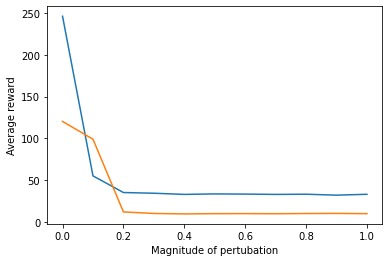

In [34]:
# Taking the gradient of the reward with respect to the temporal difference error
agent_robust.network.eval()

best_reward = 0

episode_number = []
average_reward_number_robust = []
epsilons_attacks = [0,0.1, .2, 0.3, .4, 0.5, .6, 0.7, .8, .9, 1] 


for epsilon in epsilons_attacks:
    average_reward_robust = 0
    for i in range(1,EPISODES_TEST):
        state = env.reset()
        score = 0
        while True:
            action, q_values = agent_robust.choose_action(state)
            state_, reward, done, info = env.step(action)

#             if score % 1 == 0 and not(isinstance(q_values,float)):
#                 next_q_values = agent_robust.network(state_.to(DEVICE).float()).detach()
#                 loss = agent_robust.network.loss(q_values, next_q_values)

#                 gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
#                 state = state + gradient_sign * epsilon
#                 action, q_values = agent_robust.choose_action(state)
#                 state_, reward, done, info = env.step(action)

            if score % 1 == 0 and not(isinstance(q_values,float)):
                next_q_values = agent.network(state_.to(DEVICE).float()).detach()
                q_target = reward + GAMMA * next_q_values * done
                loss = agent.network.loss(q_values, q_target)
                gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
                state = state + gradient_sign * epsilon
                action, q_values = agent.choose_action(state)
                state_, reward, done, info = env.step(action)
                did_pertubate += 1



            state = state_
            score += reward

            if done:
                if score > best_reward:
                    best_reward = score
                average_reward_robust += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_robust/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
    average_reward_number_robust.append(average_reward_robust / i)

plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_robust)
plt.plot(epsilons_attacks,average_reward_number_attacked)
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()